# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [2]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.3' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree

from functools import partial
from getdist import plots
from numpyro import infer

%matplotlib inline
%load_ext autoreload
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-01-19 21:50:18.714264: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Config and fiduc

In [32]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
task_id = 4020
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)

import jax
jax.config.update("jax_debug_nans", False)

SLURM_ARRAY_TASK_ID: 4020


In [33]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p") or True:
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 0., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, hide_det=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir)    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.condition({'obs': truth['obs']})
model.delta_obs = truth['obs'] - 1
model.block()
# model.render()

# CONFIG
{'a_lpt': 0.1,
 'a_obs': 1.0,
 'box_shape': array([640., 640., 640.]),
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'low': 0.05,
                         'scale': 0.2},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'scale': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'scale': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'bs2': {'group': 'bias',
                     'label': '{b}_{s^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'init_mesh': {'group': 'init',
               

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


n_solvsteps: 5
Saving model and truth at /feynman/home/dphp/hs276503/scratch/pickles/m128_b640.0_al0.1_ao1.0_lo2_pc2_obmesh/


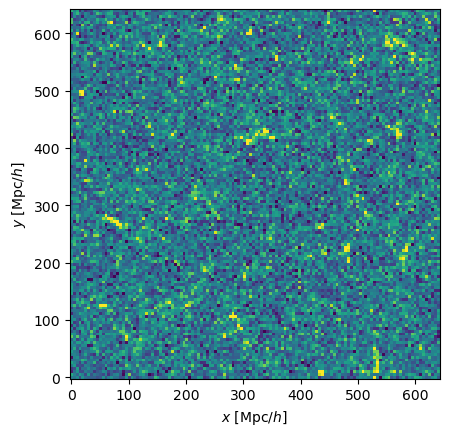

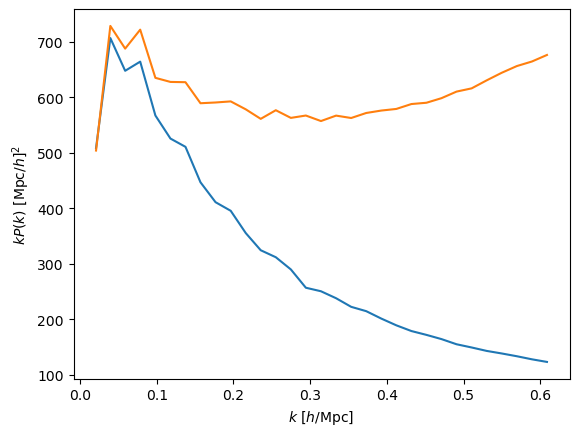

In [34]:
from montecosmo.plot import plot_pk, plot_mesh
kpk = model.spectrum(truth['obs'])
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
kpk0 = model.spectrum(mesh0)
plot_mesh(truth['obs'], model.box_shape, sli=1, vlim=1e-2)
plt.figure()
plot_pk(*kpk0)
plot_pk(*kpk)

## Run

### NUTS, HMC

In [ ]:
continue_run = False
if continue_run:
    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()
    mcmc = get_mcmc(model.model, mcmc_config)

    last_state = pload(save_path + "_last_state.p")
    mcmc.num_warmup = 0
    mcmc.post_warmup_state = last_state
    init_params_ = None
else:
    model.reset()
    model.condition({'obs': truth['obs']} | model.prior_loc, frombase=True)
    model.block()

    nuts_config = {
        'sampler':'NUTS',
        'target_accept_prob':0.65,
        'n_samples':16,
        'max_tree_depth':10,
        'n_runs':10,
        'n_chains':8
    }
    mcmc = get_mcmc(model.model, nuts_config)
    
    print("Init params")
    init_params_ = jit(vmap(model.init_model))(jr.split(jr.key(43), nuts_config['n_chains']))
    init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']} # NOTE: !!!!!!!
    mcmc = sample_and_save(mcmc, save_path+'_init', 0, 0, extra_fields=['num_steps'], init_params=init_mesh_)
    
    print("mean_acc_prob:", mcmc.last_state.mean_accept_prob, "\nss:", mcmc.last_state.adapt_state.step_size)
    init_params_ |= mcmc.last_state.z
    print(init_params_.keys())

    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()

Init params


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

run 0/0 (warmup)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

In [ ]:
if mcmc_config['sampler'] != 'NUTSwG':
    mcmc = get_mcmc(model.model, mcmc_config)
    mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)

else:
    from montecosmo.samplers import NUTSwG_init, get_NUTSwG_run

    step_fn, init_fn, parameters, init_state_fn = NUTSwG_init(model.logpdf)
    warmup_fn = jit(vmap(get_NUTSwG_run(model.logpdf, step_fn, init_fn, parameters, mcmc_config['n_samples'], warmup=True)))
    key = jr.key(42)
    last_state = jit(vmap(init_state_fn))(init_params_)
    # last_state = pload(save_dir+"NUTSGibbs/HMCGibbs_ns256_x_nc8_laststate32.p")


    (last_state, parameters), samples, infos = warmup_fn(jr.split(jr.key(43), mcmc_config['n_chains']), last_state)
    print(parameters,'\n=======\n')
    jnp.savez(save_path+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    pdump(last_state, save_path+f"_last_state.p")
    # pdump(parameters, 'parameters.p'), pdump(tree.map(jnp.mean, infos), 'infos.p')

    run_fn = jit(vmap(get_NUTSwG_run(model.logpdf, step_fn, init_fn, parameters, mcmc_config['n_samples'])))
    start = 1
    end = start + mcmc_config['n_runs']-1
    for i_run in range(start, end+1):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        # last_state, samples, infos = run_fn(jr.split(run_key, mcmc_config['n_chains']), last_state)
        last_state, samples, infos = run_fn(jr.split(run_key, mcmc_config['n_chains']), last_state)
        print("infos:", infos)
        jnp.savez(save_path+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(last_state, save_path+f"_last_state.p")

In [ ]:
# model.reset()
# model.condition({'obs': truth['obs']})
# model.block()
# mcmc = get_mcmc(model.model, mcmc_config)
# init_params_ = {k+'_': jnp.broadcast_to(truth[k+'_'], (mcmc_config['n_chains'], *jnp.shape(truth[k+'_']))) for k in ['Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']}

# mcmc_runned = sample_and_save(mcmc, mcmc_config['n_runs'], save_path, extra_fields=['num_steps'], init_params=init_params_)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc3_obmesh/
Loading: sNUTSwG_nc8_ns64_mt10_ta0.65, from run 0 to run 10 (included)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (8, 704), 'b1': (8, 704), 'b2': (8, 704), 'bn2': (8, 704), 'bs2': (8, 704), 'init_mesh': (8, 704, 10), 'n_evals': (8, 704), 'sigma8': (8, 704)}

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.33      0.02      0.33      0.29      0.36     55.64      1.14
          b1      0.98      0.04      0.99      0.91      1.05     17.41      1.33
          b2     -0.03      0.02     -0.03     -0.07      0.00     69.88      1.14
         bn2      0.17      0.23      0.14     -0.15      0.59     45.07      1.17
         bs2     -0.02      0.08     -0.02     -0.15      0.10     73.05      1.13
init_mesh[0]      2.30      1.28      2.32      0.21      4.35   2866.60      1.00
init_mesh[1]      0.45      1.35      0.46     -1.77      2.59   3078.35      1.00
init_mesh[2]      0.52      1.38      0.52     -1.71      2.83   2634.13      1.00
init_mesh[3]     -0.40      1.47     -0.39     -2.91      1.94   2319.36      1.00
init_mesh[4] 

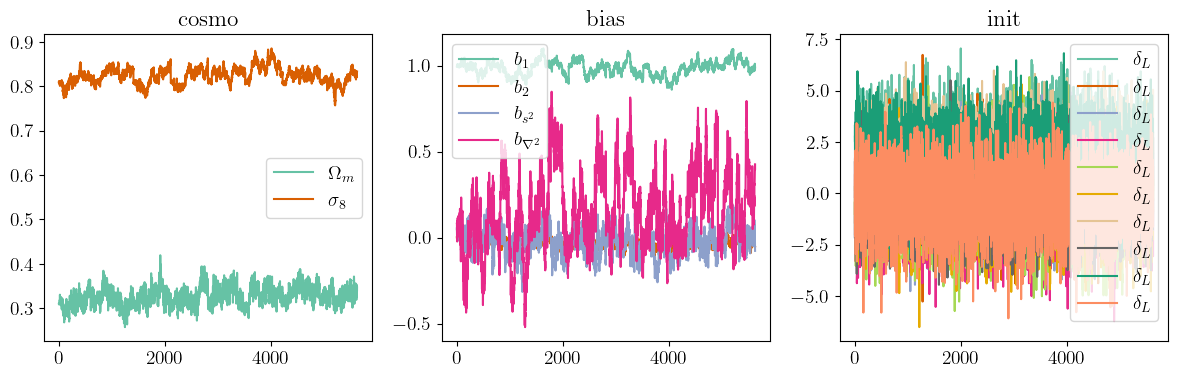

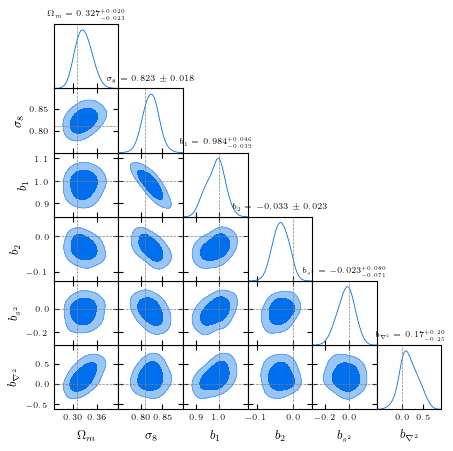

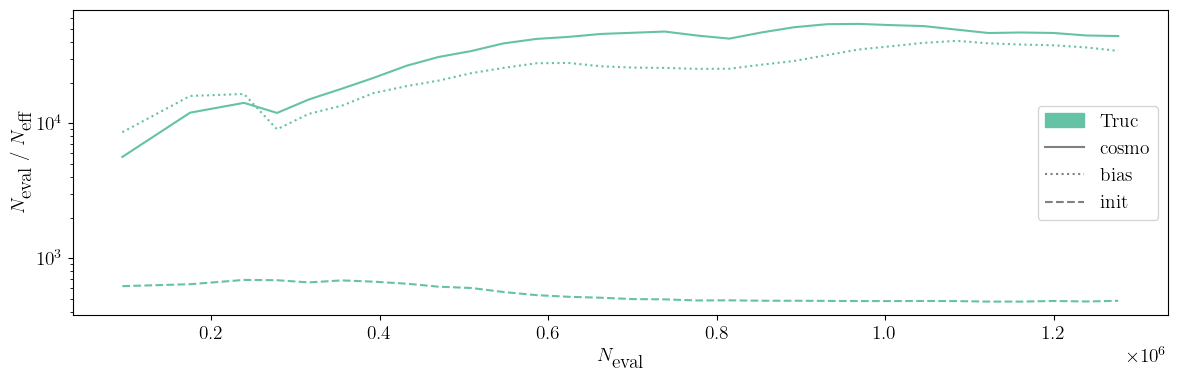

In [ ]:
from montecosmo.mcbench import Chains
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
groups = ['cosmo','bias','init']

tids = [task_id]
labels = 4*['NUTS']

metrics = []
gdsamps = []

for tid, lab in zip(tids, labels):
    model, mcmc_config, save_dir, save_path = from_id(tid)

    # Load truth
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")
    model.delta_obs = truth['obs'] - 1

    # Load chains
    transforms = [
                lambda x: x[['*~diverging']],
                partial(Chains.thin, thinning=1), 
                model.reparam_chains, 
                partial(Chains.choice, n=10)]
    chains = model.load_runs(save_path, 0,10, transforms=transforms, batch_ndim=2)
    print(chains.shape)

    # Load last state
    last_state = pload(save_path + "_last_state.p")
    # print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)

    # Plot chains
    plt.figure(figsize=(12,4))
    chains.plot(['cosmo', 'bias','init'])
    plt.tight_layout()
    plt.savefig(save_dir+f'chains_{tid}.png')
    chains.print_summary()

    # Compute metrics
    cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 30)
    metrics.append(cumess)

    # Prepare KDE
    gdsamp = chains[['cosmo','bias']].to_getdist(lab)
    gdsamps.append(gdsamp)



# Plot KDE
gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=gdsamps,
                title_limit=1,
                filled=True, 
                markers=truth,)
plt.savefig(save_dir+'triangle.png')


# Plot metrics
def plot_fn():
    plt.figure(figsize=(12, 4))
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles)

plot_fn()
plt.xlabel("$N_{\\textrm{eval}}$")
# plt.ylabel("$N_{\\textrm{eval}}\\;/\\;\\textrm{ESS}$")
plt.ylabel("$N_{\\textrm{eval}}\\;/\\;N_{\\textrm{eff}}$")
plt.tight_layout()
plt.savefig(save_dir+'cumess.png')